In [10]:
# import pathlib
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import re
#import random
#from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_auc_score
from sklearn.preprocessing import QuantileTransformer
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe


import xgboost as xgb
from sklearn.metrics import auc, accuracy_score, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV
#from string import ascii_letters
import seaborn as sns
import h5py as h5
%matplotlib inline
#from string import ascii_letters

In [2]:
df =pd.read_pickle('../pickle_pd/second_pd_top_25.pkl')
features = list(df)[:-1]

In [3]:
qt = QuantileTransformer(random_state=0)
df[features] = qt.fit_transform(df[features])

In [4]:
df.head()

,lep_pt_2,met_et,lep_pt_1,jet_n,lep_E_1,lep_eta_0,jet_pt_0,jet_pt_1,lep_phi_1,lep_eta_1,...,jet_m,jet_eta_1,lep_E_0,lep_pt_3,jet_E_0,jet_pt_2,lep_charge_1,lep_charge_0,jet_E_1,label
0,0.827001,0.380512,0.876871,0.000000,0.679856,0.299734,0.000000,0.0,0.076109,0.306802,...,0.095420,0.502002,0.450911,0.000000,0.000000,0.0,0.000000,1.0,0.0,0
1,0.000000,0.087919,0.823059,0.000000,0.629127,0.640667,0.000000,0.0,0.150230,0.683559,...,0.095420,0.502002,0.297723,0.000000,0.000000,0.0,0.000000,1.0,0.0,0
2,0.889522,0.105194,0.944168,0.413914,0.816004,0.917707,0.332354,0.0,0.813354,0.805162,...,0.139560,0.502002,0.726758,0.957515,0.419390,0.0,0.000000,1.0,0.0,0
3,0.959527,0.135238,0.738807,0.000000,0.898591,0.496582,0.000000,0.0,0.862741,0.939720,...,0.139560,0.502002,0.010326,0.976537,0.000000,0.0,1.000000,0.0,0.0,0
4,0.000000,0.789771,0.000000,0.413914,0.000000,0.497493,0.906905,0.0,0.500501,0.498498,...,0.906466,0.502002,0.466519,0.000000,0.783745,0.0,0.504004,1.0,0.0,0


In [5]:
 X_train, X_test, y_train, y_test = train_test_split( df[features], df['label'], test_size=0.4, random_state=42,shuffle = True)
 X_test, X_val, y_test, y_val = train_test_split( X_test, y_test, test_size=0.5, random_state=42,shuffle = True)

In [88]:
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        #'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 1,50,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.6,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': hp.choice('n_estimators', [300, 400, 500, 600]),
        'seed': 0
    }

In [89]:
def objective(space):
    clf=xgb.XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']),
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']), reg_lambda= space['reg_lambda'])
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation, #eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(X_train)
    accuracy = accuracy_score(y_train, pred)
    pred_val = clf.predict(X_test)
    val_accuracy = accuracy_score(y_test, pred_val)
    delta_accuracy = accuracy - val_accuracy
    print ("SCORE:", accuracy)
    return {'loss': -val_accuracy, 'accuracy': accuracy, 'val_accuracy': val_accuracy, 'delta_accuracy':delta_accuracy, 'status': STATUS_OK }

In [90]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 50,
                        trials = trials)

  0%|                                  | 0/50 [00:00<?, ?trial/s, best loss=?]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                        
0.8110158343015719                                                            
  2%|▏      | 1/50 [00:52<43:15, 52.97s/trial, best loss: -0.8076165967294341]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                        
0.8090889595196257                                                            
  4%|▎      | 2/50 [01:38<38:46, 48.47s/trial, best loss: -0.8076165967294341]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                        
0.8116431888817405                                                            
  6%|▍      | 3/50 [02:40<43:00, 54.90s/trial, best loss: -0.8076165967294341]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                        
0.8768752620645727                                                            
  8%|▌      | 4/50 [03:16<36:08, 47.15s/trial, best loss: -0.8076165967294341]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                        
0.8077190219670126                                                            
 10%|▋      | 5/50 [03:44<30:17, 40.38s/trial, best loss: -0.8076165967294341]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                        
0.8120656929867519                                                            
 12%|▊      | 6/50 [04:37<32:50, 44.77s/trial, best loss: -0.8076165967294341]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                        
0.8078086440498939                                                            
 14%|▉      | 7/50 [05:07<28:36, 39.91s/trial, best loss: -0.8076165967294341]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                        
0.8099563732503688                                                            
 16%|█      | 8/50 [05:54<29:22, 41.95s/trial, best loss: -0.8076165967294341]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                        
0.8094378454851275                                                            
 18%|█▍      | 9/50 [06:44<30:32, 44.69s/trial, best loss: -0.807722222755687]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                        
0.8146359262922384                                                            
 20%|█▍     | 10/50 [07:48<33:48, 50.71s/trial, best loss: -0.807722222755687]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                        
0.8085352230789666                                                            
 22%|█▌     | 11/50 [08:53<35:48, 55.08s/trial, best loss: -0.807722222755687]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                        
0.8102604481744302                                                            
 24%|█▋     | 12/50 [09:47<34:36, 54.65s/trial, best loss: -0.807751029853756]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                        
0.8091753808138326                                                            
 26%|█▊     | 13/50 [11:13<39:34, 64.18s/trial, best loss: -0.807751029853756]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                        
0.8117904251607596                                                            
 28%|█▉     | 14/50 [12:44<43:25, 72.37s/trial, best loss: -0.807751029853756]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                        
0.8480009474334476                                                            
 30%|██     | 15/50 [13:47<40:29, 69.41s/trial, best loss: -0.807751029853756]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                        
0.8139637606706293                                                            
 32%|██▏    | 16/50 [15:21<43:35, 76.93s/trial, best loss: -0.807751029853756]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                        
0.8172765769485602                                                            
 34%|██▍    | 17/50 [16:35<41:43, 75.86s/trial, best loss: -0.807751029853756]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                        
0.8078470535139859                                                            
 36%|██▌    | 18/50 [17:20<35:28, 66.50s/trial, best loss: -0.807751029853756]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                        
0.808800888538936                                                             
 38%|██▋    | 19/50 [18:13<32:21, 62.64s/trial, best loss: -0.807751029853756]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                        
0.8205797908604681                                                            
 40%|██▊    | 20/50 [19:07<29:57, 59.91s/trial, best loss: -0.807751029853756]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                        
0.8091913847572042                                                            
 42%|██▌   | 21/50 [20:05<28:40, 59.33s/trial, best loss: -0.8079814866383077]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                        
0.8092393965873191                                                            
 44%|██▋   | 22/50 [21:02<27:23, 58.69s/trial, best loss: -0.8079814866383077]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                        
0.8091369713497406                                                            
 46%|██▊   | 23/50 [21:58<26:06, 58.02s/trial, best loss: -0.8079814866383077]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                        
0.809130569772392                                                             
 48%|██▉   | 24/50 [22:55<25:01, 57.76s/trial, best loss: -0.8079814866383077]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                        
0.809549873088729                                                             
 50%|█▌ | 25/50 [56:48<4:30:54, 650.20s/trial, best loss: -0.8079814866383077]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                        
0.8096747038470279                                                            
 52%|▌| 26/50 [3:38:35<22:26:59, 3367.50s/trial, best loss: -0.807981486638307

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                        
0.8098635503788133                                                            
 54%|▌| 27/50 [6:28:27<34:35:45, 5415.04s/trial, best loss: -0.807981486638307

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                        
0.810190030823595                                                             
 56%|▌| 28/50 [9:27:48<42:53:38, 7019.00s/trial, best loss: -0.807981486638307

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                        
0.8113807242104455                                                            
 58%|▌| 29/50 [10:00:24<32:04:59, 5499.96s/trial, best loss: -0.80798148663830

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                        
0.8098251409147214                                                            
 60%|▌| 30/50 [10:01:19<21:28:46, 3866.30s/trial, best loss: -0.80801029373637

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                        
0.809335420247549                                                             
 62%|▌| 31/50 [10:02:19<14:22:43, 2724.37s/trial, best loss: -0.80801029373637

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                        
0.8143574576775717                                                            
 64%|▋| 32/50 [10:03:08<9:36:32, 1921.79s/trial, best loss: -0.808010293736376

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                        
0.8109774248374799                                                            
 66%|▋| 33/50 [10:04:21<6:27:24, 1367.30s/trial, best loss: -0.808010293736376

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                        
0.8100748024313191                                                            
 68%|▋| 34/50 [10:05:32<4:20:55, 978.46s/trial, best loss: -0.8080102937363767

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                        
0.8088617035237482                                                            
 70%|▋| 35/50 [10:06:23<2:55:03, 700.23s/trial, best loss: -0.8080102937363767

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                        
0.8096490975376333                                                            
 72%|▋| 36/50 [10:07:07<1:57:27, 503.40s/trial, best loss: -0.8080102937363767

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                        
0.8108333893471351                                                            
 74%|▋| 37/50 [10:08:36<1:22:07, 379.07s/trial, best loss: -0.8080102937363767

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                        
0.8078502543026602                                                            
 76%|█▌| 38/50 [10:09:21<55:45, 278.76s/trial, best loss: -0.8080102937363767]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                        
0.8109742240488056                                                            
 78%|█▌| 39/50 [10:10:38<39:58, 218.08s/trial, best loss: -0.8080102937363767]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                        
0.8087848845955643                                                            
 80%|█▌| 40/50 [10:11:13<27:11, 163.15s/trial, best loss: -0.8080102937363767]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                        
0.8090025382254188                                                            
 82%|█▋| 41/50 [10:12:12<19:47, 131.90s/trial, best loss: -0.8080102937363767]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                        
0.8110702477090355                                                            
 84%|█▋| 42/50 [10:13:49<16:11, 121.47s/trial, best loss: -0.8080102937363767]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                        
0.8086376483165452                                                            
 86%|█▋| 43/50 [10:14:44<11:50, 101.54s/trial, best loss: -0.8080102937363767]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                        
0.808480809671503                                                             
 88%|██▋| 44/50 [10:15:33<08:35, 85.99s/trial, best loss: -0.8080102937363767]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                        
0.8094442470624762                                                            
 90%|██▋| 45/50 [10:16:57<07:06, 85.36s/trial, best loss: -0.8080102937363767]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                        
0.8095306683566831                                                            
 92%|██▊| 46/50 [10:18:19<05:36, 84.17s/trial, best loss: -0.8080102937363767]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                        
0.8096554991149819                                                            
 94%|██▊| 47/50 [10:19:08<03:41, 73.77s/trial, best loss: -0.8080102937363767]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                        
0.8117904251607596                                                            
 96%|██▉| 48/50 [10:20:38<02:37, 78.60s/trial, best loss: -0.8080102937363767]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                        
0.8158874346639012                                                            
 98%|██▉| 49/50 [10:22:27<01:27, 87.76s/trial, best loss: -0.8080102937363767]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                        
0.8084648057281314                                                            
100%|██| 50/50 [10:23:20<00:00, 748.01s/trial, best loss: -0.8080102937363767]


In [91]:
best_hyperparams

{'colsample_bytree': 0.7835361011051029,
 'max_depth': 4.0,
 'min_child_weight': 7.0,
 'n_estimators': 3,
 'reg_alpha': 33.0,
 'reg_lambda': 0.46159501019482946}

In [102]:
trial_res = pd.DataFrame()
for keys in trials.trials[0]['misc']['vals'].keys():
    trial_res[keys] = pd.Series([trial['misc']['vals'][keys] for trial in trials.trials])
trial_res = trial_res.apply(pd.Series.squeeze)
trial_res['train_accuracy'] = [trial['result']['accuracy'] for trial in trials.trials]
trial_res['val_accuracy'] = [trial['result']['val_accuracy'] for trial in trials.trials]
trial_res['delta_accuracy'] = [trial['result']['delta_accuracy'] for trial in trials.trials]
col_names = list(trial_res)
trial_res = pd.concat((pd.DataFrame(trial_res[col].tolist()) for col in list(trial_res)), axis=1)
trial_res.columns = col_names
trial_res['Selection'] = np.zeros(len(trial_res))
trial_res['Selection'][trials.best_trial['tid']] = "best"
for i, n in zip([300, 400, 500, 600], [300, 400, 500, 600]):
    trial_res['n_estimators'][trial_res['n_estimators']== i] = n

/var/folders/jg/_qgpsg4n22d16c3lpjt2qdk80000gn/T/ipykernel_54711/2052536915.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trial_res['Selection'][trials.best_trial['tid']] = "best"
/var/folders/jg/_qgpsg4n22d16c3lpjt2qdk80000gn/T/ipykernel_54711/2052536915.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trial_res['n_estimators'][trial_res['n_estimators']== i] = n
/var/folders/jg/_qgpsg4n22d16c3lpjt2qdk80000gn/T/ipykernel_54711/2052536915.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

In [108]:
trial_res.to_csv('out.csv',index=False)

In [6]:
trial_res = pd.read_csv('out.csv')

In [15]:
trial_res.head()

,colsample_bytree,max_depth,min_child_weight,n_estimators,reg_alpha,reg_lambda,train_accuracy,val_accuracy,delta_accuracy,Selection
0,0.691505,8.0,4.0,2,27.0,0.112930,0.811016,0.807617,0.003399,0.0
1,0.841174,7.0,0.0,2,46.0,0.597406,0.809089,0.807223,0.001866,0.0
2,0.758157,14.0,6.0,2,26.0,0.962773,0.811643,0.807559,0.004084,0.0
3,0.744317,14.0,1.0,0,1.0,0.783146,0.876875,0.796497,0.080378,0.0
4,0.710051,6.0,5.0,0,46.0,0.741247,0.807719,0.806147,0.001572,0.0


In [12]:
best_hyperparams = {'colsample_bytree': 0.7835361011051029,
 'max_depth': 4.0,
 'min_child_weight': 7.0,
 'n_estimators': 3,
 'reg_alpha': 33.0,
 'reg_lambda': 0.46159501019482946}

In [13]:
%matplotlib inline
sns.set(font_scale = 3)
sns.pairplot(trial_res, x_vars=['n_estimators', 'colsample_bytree', 'max_depth', 'min_child_weight', 'reg_alpha', 'reg_lambda' ], y_vars=['train_accuracy','val_accuracy','delta_accuracy'], kind='reg',  height=5, hue = 'Selection')


In [ ]:
%matplotlib inline
sns.set(font_scale = 3)
sns.pairplot(trial_res, x_vars=['n_estimators', 'colsample_bytree', 'max_depth', 'min_child_weight', 'reg_alpha', 'reg_lambda' ], y_vars=['train_accuracy','val_accuracy','delta_accuracy'], kind='reg',  height=5, hue = 'Selection')
plt.show()
#sns.pairplot(trial_res.head(1), x_vars=[ 'colsample_bytree', 'gamma', 'max_depth', 'min_child_weight', 'reg_alpha', 'reg_lambda' ], y_vars=['accuracy','val_accuracy','delta_accuracy'], kind='reg',  height=5)

In [106]:
sns.set(font_scale = 3)
sns.pairplot(trial_res, x_vars=['n_estimators', 'colsample_bytree', 'max_depth', 'min_child_weight', 'reg_alpha', 'reg_lambda' ], y_vars=['train_accuracy','val_accuracy','delta_accuracy'], kind='reg',  height=5, hue = 'Selection')

In [105]:
best_hyperparams

{'colsample_bytree': 0.7835361011051029,
 'max_depth': 4.0,
 'min_child_weight': 7.0,
 'n_estimators': 3,
 'reg_alpha': 33.0,
 'reg_lambda': 0.46159501019482946}

In [95]:
xgb_model=xgb.XGBClassifier(
                    n_estimators =[200,300,400, 500, 600][best_hyperparams['n_estimators']], max_depth = int(best_hyperparams['max_depth']),
                    reg_alpha = int(best_hyperparams['reg_alpha']),min_child_weight=int(best_hyperparams['min_child_weight']),
                    colsample_bytree=int(best_hyperparams['colsample_bytree']), reg_lambda= space['reg_lambda'])         
xgb_model.fit(X_train[features],y_train,
             eval_set = [( X_train, y_train), ( X_test, y_test)])
#y_pred = xgb_model.predict(X_val[features])

[0]	validation_0-mlogloss:1.02997	validation_1-mlogloss:1.03017
[1]	validation_0-mlogloss:0.96435	validation_1-mlogloss:0.96494
[2]	validation_0-mlogloss:0.95278	validation_1-mlogloss:0.95359
[3]	validation_0-mlogloss:0.91447	validation_1-mlogloss:0.91577
[4]	validation_0-mlogloss:0.89488	validation_1-mlogloss:0.89633
[5]	validation_0-mlogloss:0.88567	validation_1-mlogloss:0.88718
[6]	validation_0-mlogloss:0.88293	validation_1-mlogloss:0.88449
[7]	validation_0-mlogloss:0.86506	validation_1-mlogloss:0.86668
[8]	validation_0-mlogloss:0.85043	validation_1-mlogloss:0.85198
[9]	validation_0-mlogloss:0.82917	validation_1-mlogloss:0.83058
[10]	validation_0-mlogloss:0.76074	validation_1-mlogloss:0.76119
[11]	validation_0-mlogloss:0.72569	validation_1-mlogloss:0.72607
[12]	validation_0-mlogloss:0.69752	validation_1-mlogloss:0.69804
[13]	validation_0-mlogloss:0.69008	validation_1-mlogloss:0.69068
[14]	validation_0-mlogloss:0.67513	validation_1-mlogloss:0.67561
[15]	validation_0-mlogloss:0.67056	

[126]	validation_0-mlogloss:0.46176	validation_1-mlogloss:0.46353
[127]	validation_0-mlogloss:0.46166	validation_1-mlogloss:0.46345
[128]	validation_0-mlogloss:0.46144	validation_1-mlogloss:0.46327
[129]	validation_0-mlogloss:0.46136	validation_1-mlogloss:0.46319
[130]	validation_0-mlogloss:0.46126	validation_1-mlogloss:0.46310
[131]	validation_0-mlogloss:0.46102	validation_1-mlogloss:0.46285
[132]	validation_0-mlogloss:0.46097	validation_1-mlogloss:0.46282
[133]	validation_0-mlogloss:0.46069	validation_1-mlogloss:0.46258
[134]	validation_0-mlogloss:0.46025	validation_1-mlogloss:0.46209
[135]	validation_0-mlogloss:0.46007	validation_1-mlogloss:0.46189
[136]	validation_0-mlogloss:0.45922	validation_1-mlogloss:0.46105
[137]	validation_0-mlogloss:0.45900	validation_1-mlogloss:0.46083
[138]	validation_0-mlogloss:0.45879	validation_1-mlogloss:0.46064
[139]	validation_0-mlogloss:0.45865	validation_1-mlogloss:0.46054
[140]	validation_0-mlogloss:0.45837	validation_1-mlogloss:0.46029
[141]	vali

[251]	validation_0-mlogloss:0.44995	validation_1-mlogloss:0.45275
[252]	validation_0-mlogloss:0.44987	validation_1-mlogloss:0.45269
[253]	validation_0-mlogloss:0.44981	validation_1-mlogloss:0.45261
[254]	validation_0-mlogloss:0.44980	validation_1-mlogloss:0.45261
[255]	validation_0-mlogloss:0.44978	validation_1-mlogloss:0.45260
[256]	validation_0-mlogloss:0.44973	validation_1-mlogloss:0.45256
[257]	validation_0-mlogloss:0.44967	validation_1-mlogloss:0.45253
[258]	validation_0-mlogloss:0.44961	validation_1-mlogloss:0.45247
[259]	validation_0-mlogloss:0.44960	validation_1-mlogloss:0.45246
[260]	validation_0-mlogloss:0.44954	validation_1-mlogloss:0.45242
[261]	validation_0-mlogloss:0.44952	validation_1-mlogloss:0.45241
[262]	validation_0-mlogloss:0.44920	validation_1-mlogloss:0.45208
[263]	validation_0-mlogloss:0.44918	validation_1-mlogloss:0.45208
[264]	validation_0-mlogloss:0.44908	validation_1-mlogloss:0.45197
[265]	validation_0-mlogloss:0.44904	validation_1-mlogloss:0.45194
[266]	vali

[376]	validation_0-mlogloss:0.44629	validation_1-mlogloss:0.44995
[377]	validation_0-mlogloss:0.44626	validation_1-mlogloss:0.44993
[378]	validation_0-mlogloss:0.44624	validation_1-mlogloss:0.44992
[379]	validation_0-mlogloss:0.44623	validation_1-mlogloss:0.44993
[380]	validation_0-mlogloss:0.44621	validation_1-mlogloss:0.44991
[381]	validation_0-mlogloss:0.44621	validation_1-mlogloss:0.44991
[382]	validation_0-mlogloss:0.44619	validation_1-mlogloss:0.44989
[383]	validation_0-mlogloss:0.44617	validation_1-mlogloss:0.44988
[384]	validation_0-mlogloss:0.44616	validation_1-mlogloss:0.44988
[385]	validation_0-mlogloss:0.44615	validation_1-mlogloss:0.44986
[386]	validation_0-mlogloss:0.44613	validation_1-mlogloss:0.44985
[387]	validation_0-mlogloss:0.44613	validation_1-mlogloss:0.44985
[388]	validation_0-mlogloss:0.44612	validation_1-mlogloss:0.44984
[389]	validation_0-mlogloss:0.44609	validation_1-mlogloss:0.44982
[390]	validation_0-mlogloss:0.44608	validation_1-mlogloss:0.44982
[391]	vali

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=0,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=7, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [99]:
xgb_model2=xgb.XGBClassifier(
                    n_estimators =200, max_depth = int(best_hyperparams['max_depth']),
                    reg_alpha = int(best_hyperparams['reg_alpha']),min_child_weight=int(best_hyperparams['min_child_weight']),
                    colsample_bytree=int(best_hyperparams['colsample_bytree']), reg_lambda= space['reg_lambda'])         
xgb_model2.fit(X_train[features],y_train,
             eval_set = [( X_train, y_train), ( X_test, y_test)])

[0]	validation_0-mlogloss:1.02997	validation_1-mlogloss:1.03017
[1]	validation_0-mlogloss:0.96435	validation_1-mlogloss:0.96494
[2]	validation_0-mlogloss:0.95278	validation_1-mlogloss:0.95359
[3]	validation_0-mlogloss:0.91447	validation_1-mlogloss:0.91577
[4]	validation_0-mlogloss:0.89488	validation_1-mlogloss:0.89633
[5]	validation_0-mlogloss:0.88567	validation_1-mlogloss:0.88718
[6]	validation_0-mlogloss:0.88293	validation_1-mlogloss:0.88449
[7]	validation_0-mlogloss:0.86506	validation_1-mlogloss:0.86668
[8]	validation_0-mlogloss:0.85043	validation_1-mlogloss:0.85198
[9]	validation_0-mlogloss:0.82917	validation_1-mlogloss:0.83058
[10]	validation_0-mlogloss:0.76074	validation_1-mlogloss:0.76119
[11]	validation_0-mlogloss:0.72569	validation_1-mlogloss:0.72607
[12]	validation_0-mlogloss:0.69752	validation_1-mlogloss:0.69804
[13]	validation_0-mlogloss:0.69008	validation_1-mlogloss:0.69068
[14]	validation_0-mlogloss:0.67513	validation_1-mlogloss:0.67561
[15]	validation_0-mlogloss:0.67056	

[126]	validation_0-mlogloss:0.46176	validation_1-mlogloss:0.46353
[127]	validation_0-mlogloss:0.46166	validation_1-mlogloss:0.46345
[128]	validation_0-mlogloss:0.46144	validation_1-mlogloss:0.46327
[129]	validation_0-mlogloss:0.46136	validation_1-mlogloss:0.46319
[130]	validation_0-mlogloss:0.46126	validation_1-mlogloss:0.46310
[131]	validation_0-mlogloss:0.46102	validation_1-mlogloss:0.46285
[132]	validation_0-mlogloss:0.46097	validation_1-mlogloss:0.46282
[133]	validation_0-mlogloss:0.46069	validation_1-mlogloss:0.46258
[134]	validation_0-mlogloss:0.46025	validation_1-mlogloss:0.46209
[135]	validation_0-mlogloss:0.46007	validation_1-mlogloss:0.46189
[136]	validation_0-mlogloss:0.45922	validation_1-mlogloss:0.46105
[137]	validation_0-mlogloss:0.45900	validation_1-mlogloss:0.46083
[138]	validation_0-mlogloss:0.45879	validation_1-mlogloss:0.46064
[139]	validation_0-mlogloss:0.45865	validation_1-mlogloss:0.46054
[140]	validation_0-mlogloss:0.45837	validation_1-mlogloss:0.46029
[141]	vali

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=0,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=7, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [96]:
xgb_basic=xgb.XGBClassifier(n_estimators =180) 
evals_result = {}
xgb_basic.fit(X_train[features],y_train,
             eval_set = [( X_train, y_train), ( X_test, y_test)])

[0]	validation_0-mlogloss:0.87346	validation_1-mlogloss:0.87372
[1]	validation_0-mlogloss:0.74193	validation_1-mlogloss:0.74242
[2]	validation_0-mlogloss:0.65647	validation_1-mlogloss:0.65729
[3]	validation_0-mlogloss:0.59772	validation_1-mlogloss:0.59891
[4]	validation_0-mlogloss:0.55684	validation_1-mlogloss:0.55860
[5]	validation_0-mlogloss:0.52746	validation_1-mlogloss:0.52964
[6]	validation_0-mlogloss:0.50498	validation_1-mlogloss:0.50766
[7]	validation_0-mlogloss:0.48796	validation_1-mlogloss:0.49093
[8]	validation_0-mlogloss:0.47464	validation_1-mlogloss:0.47786
[9]	validation_0-mlogloss:0.46436	validation_1-mlogloss:0.46801
[10]	validation_0-mlogloss:0.45625	validation_1-mlogloss:0.46015
[11]	validation_0-mlogloss:0.44924	validation_1-mlogloss:0.45354
[12]	validation_0-mlogloss:0.44394	validation_1-mlogloss:0.44865
[13]	validation_0-mlogloss:0.43916	validation_1-mlogloss:0.44419
[14]	validation_0-mlogloss:0.43485	validation_1-mlogloss:0.44018
[15]	validation_0-mlogloss:0.43183	

[126]	validation_0-mlogloss:0.31930	validation_1-mlogloss:0.35766
[127]	validation_0-mlogloss:0.31837	validation_1-mlogloss:0.35705
[128]	validation_0-mlogloss:0.31792	validation_1-mlogloss:0.35699
[129]	validation_0-mlogloss:0.31773	validation_1-mlogloss:0.35697
[130]	validation_0-mlogloss:0.31738	validation_1-mlogloss:0.35679
[131]	validation_0-mlogloss:0.31703	validation_1-mlogloss:0.35673
[132]	validation_0-mlogloss:0.31616	validation_1-mlogloss:0.35606
[133]	validation_0-mlogloss:0.31558	validation_1-mlogloss:0.35561
[134]	validation_0-mlogloss:0.31532	validation_1-mlogloss:0.35553
[135]	validation_0-mlogloss:0.31477	validation_1-mlogloss:0.35538
[136]	validation_0-mlogloss:0.31425	validation_1-mlogloss:0.35516
[137]	validation_0-mlogloss:0.31389	validation_1-mlogloss:0.35503
[138]	validation_0-mlogloss:0.31347	validation_1-mlogloss:0.35491
[139]	validation_0-mlogloss:0.31323	validation_1-mlogloss:0.35495
[140]	validation_0-mlogloss:0.31299	validation_1-mlogloss:0.35494
[141]	vali

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=180, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [87]:
pred_test = xgb_basic.predict(X_test)
accuracy_score(pred_test,y_test)

0.8605256335160983

In [82]:
history['validation_0']

OrderedDict([('mlogloss',
              [1.0299139693778374,
               0.9642582152682332,
               0.9526752408402622,
               0.9143608759322442,
               0.8947415309752578,
               0.885519264590552,
               0.8827564834998758,
               0.8648786377503181,
               0.8502338898963625,
               0.8289551499152263,
               0.7605124137898133,
               0.7254753653832233,
               0.6973066893917761,
               0.6898730878041962,
               0.6749113359092296,
               0.6703300745068073,
               0.6555456618632755,
               0.6453962718922382,
               0.6381790201148404,
               0.6221671015857568,
               0.6126696356701993,
               0.6088216351189844,
               0.6038847661689342,
               0.6022346566841581,
               0.5900964627554525,
               0.5837253215512864,
               0.5796191109093122,
               0.5705885592770

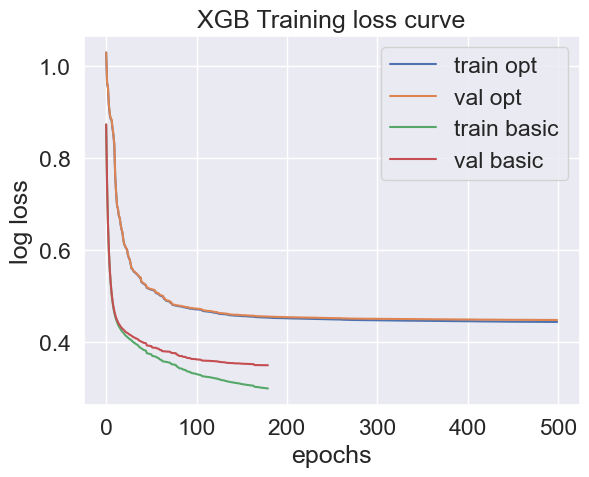

In [98]:
sns.set(font_scale = 1.5)
history  = xgb_model.evals_result()
history2  = xgb_basic.evals_result()
plt.plot(history['validation_0']['mlogloss'], label='train opt')
plt.plot(history['validation_1']['mlogloss'], label='val opt')
plt.plot(history2['validation_0']['mlogloss'], label='train basic')
plt.plot(history2['validation_1']['mlogloss'], label='val basic')
plt.ylabel('log loss')
plt.xlabel('epochs')
plt.title('XGB Training loss curve')
plt.legend()

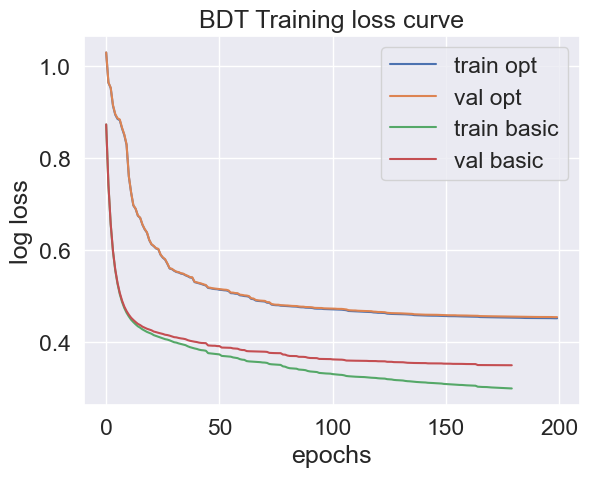

In [101]:
sns.set(font_scale = 1.5)
history  = xgb_model2.evals_result()
history2  = xgb_basic.evals_result()
plt.plot(history['validation_0']['mlogloss'], label='train opt')
plt.plot(history['validation_1']['mlogloss'], label='val opt')
plt.plot(history2['validation_0']['mlogloss'], label='train basic')
plt.plot(history2['validation_1']['mlogloss'], label='val basic')
plt.ylabel('log loss')
plt.xlabel('epochs')
plt.title('BDT Training loss curve')
plt.legend()

In [ ]:
history.keys()

In [ ]:
history['validation_0']

In [ ]:
plt.plot(history['validation_0']['mlogloss'], label='train')
plt.plot(history['validation_1']['mlogloss'], label='test')
plt.legend()

In [ ]:
y_pred =  xgb_model.predict(X_val)
y_pred_train = xgb_model.predict(X_train)